In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_06 import *

# ConvNet

In [3]:
x_train, y_train, x_valid, y_valid = get_data()

In [4]:
x_train.mean(), x_train.std()

(tensor(-9.9649e-10), tensor(1.0000))

In [5]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

In [6]:
nh, bs = 50, 512
c = y_train.max().item() + 1
loss_func = F.cross_entropy

In [7]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [8]:
mnist_view = view_tfm(1,28,28)

In [9]:
cbfs = [Recorder,
       partial(AvgStatsCallback, accuracy),
       CudaCallback,
       partial(BatchTransformXCallback, mnist_view)]

In [10]:
nfs = [8, 16, 32, 64, 64]

In [11]:
sched = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1), sched_cos(1., 0.1)])

In [12]:
# learn, run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs+[partial(ParamScheduler, 'lr', sched)])

In [13]:
cbfs = [partial(BatchTransformXCallback, mnist_view),
       Recorder,
       partial(AvgStatsCallback, accuracy),
       CudaCallback]

In [14]:
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs + [partial(ParamScheduler, 'lr', sched)])

In [15]:
run.fit(2, learn)

train: [1.1761963541666667, tensor(0.6383, device='cuda:0')]
valid: [0.29950830078125, tensor(0.9097, device='cuda:0')]
train: [0.11837305501302084, tensor(0.9646, device='cuda:0')]
valid: [0.07549603881835938, tensor(0.9762, device='cuda:0')]


# Batchnorm

## Custom

In [16]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom, self.eps = mom, eps
        self.mults = nn.Parameter(torch.ones(nf,1,1))
        self.adds = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('means', torch.zeros(1, nf, 1, 1))
        self.register_buffer('vars', torch.ones(1, nf, 1, 1))
        
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v = self.means, self.vars
        x = (x - m) / (v + self.eps).sqrt()
        return x * self.mults + self.adds
    
    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var((0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_(v, self.mom)
        return m,v

In [17]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # no bias needed if using bn
    layers = [nn.Conv2d(ni, nf, ks, stride, padding=ks//2, bias=not bn),
             GeneralRelu(**kwargs)]
    if bn: layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)

In [18]:
#export
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [19]:
#export
def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_uniform_
    init_cnn_(m, f)

In [20]:
#export
def init_cnn_(m, f):
    if isinstance(m, nn.Conv2d):
        f(m.weight, a=0.1)
        if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
    for l in m.children(): init_cnn_(l, f)

In [21]:
learn, run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs)

train: [0.24558063151041667, tensor(0.9233, device='cuda:0')]
valid: [0.2298282958984375, tensor(0.9220, device='cuda:0')]


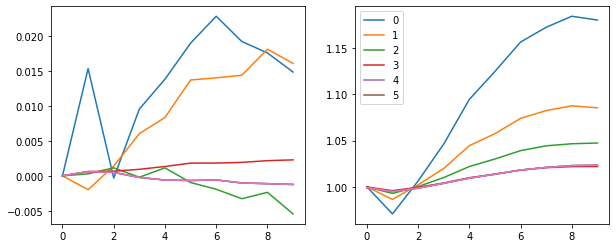

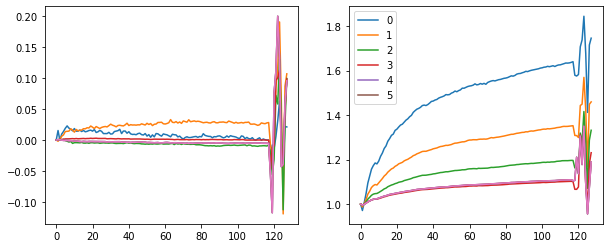

In [22]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    
    fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms, ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6));
    
    fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms, ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6));

In [23]:
learn, run = get_learn_run(nfs, data, 1.0, conv_layer, cbs=cbfs)

In [24]:
%time run.fit(3, learn)

train: [0.23984812825520832, tensor(0.9260, device='cuda:0')]
valid: [0.61205849609375, tensor(0.8318, device='cuda:0')]
train: [0.07844217122395833, tensor(0.9760, device='cuda:0')]
valid: [0.058468017578125, tensor(0.9814, device='cuda:0')]
train: [0.05518968098958334, tensor(0.9830, device='cuda:0')]
valid: [0.313597216796875, tensor(0.9233, device='cuda:0')]
CPU times: user 4.65 s, sys: 493 ms, total: 5.14 s
Wall time: 4.54 s


In [25]:
#export
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, stride, padding=ks//2, bias=not bn),
             GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [26]:
learn, run = get_learn_run(nfs, data, 1.0, conv_layer, cbs=cbfs)

In [27]:
%time run.fit(3, learn)

train: [0.19976005859375, tensor(0.9385, device='cuda:0')]
valid: [0.23870517578125, tensor(0.9179, device='cuda:0')]
train: [0.06157894287109375, tensor(0.9805, device='cuda:0')]
valid: [0.07486297607421875, tensor(0.9764, device='cuda:0')]
train: [0.040831327311197915, tensor(0.9871, device='cuda:0')]
valid: [0.044709988403320314, tensor(0.9853, device='cuda:0')]
CPU times: user 4.17 s, sys: 512 ms, total: 4.69 s
Wall time: 4.09 s


In [28]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.6, 2), sched_lin(2., 0.1)])

In [29]:
learn, run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs + [partial(ParamScheduler, 'lr', sched)])

In [30]:
run.fit(8, learn)

train: [0.216532275390625, tensor(0.9352, device='cuda:0')]
valid: [0.1842805908203125, tensor(0.9451, device='cuda:0')]
train: [0.07254474283854166, tensor(0.9776, device='cuda:0')]
valid: [0.1424078125, tensor(0.9604, device='cuda:0')]
train: [0.05445105794270833, tensor(0.9831, device='cuda:0')]
valid: [0.280080712890625, tensor(0.9259, device='cuda:0')]
train: [0.04809547119140625, tensor(0.9852, device='cuda:0')]
valid: [0.04421014404296875, tensor(0.9856, device='cuda:0')]
train: [0.021032356770833333, tensor(0.9934, device='cuda:0')]
valid: [0.040951129150390626, tensor(0.9861, device='cuda:0')]
train: [0.011753427124023438, tensor(0.9968, device='cuda:0')]
valid: [0.03609167175292969, tensor(0.9872, device='cuda:0')]
train: [0.008031184895833333, tensor(0.9983, device='cuda:0')]
valid: [0.03392394409179687, tensor(0.9883, device='cuda:0')]
train: [0.0057138448079427084, tensor(0.9990, device='cuda:0')]
valid: [0.03418860168457031, tensor(0.9887, device='cuda:0')]


## More norms

### Layer norm

In [31]:
class LayerNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add = nn.Parameter(tensor(0.))
        
    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True)
        v = x.var((1,2,3), keepdim=True)
        x = (x - m) / (v + self.eps).sqrt()
        return x * self.mult + self.add

In [32]:
def conv_ln(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, stride, padding=ks//2, bias=True),
             GeneralRelu(**kwargs)]
    if bn: layers.append(LayerNorm())
    return nn.Sequential(*layers)

In [33]:
learn,run = get_learn_run(nfs, data, 0.8, conv_ln, cbs=cbfs)

In [34]:
%time run.fit(3, learn)

train: [nan, tensor(0.1081, device='cuda:0')]
valid: [nan, tensor(0.0980, device='cuda:0')]
train: [nan, tensor(0.0987, device='cuda:0')]
valid: [nan, tensor(0.0980, device='cuda:0')]
train: [nan, tensor(0.0987, device='cuda:0')]
valid: [nan, tensor(0.0980, device='cuda:0')]
CPU times: user 5.36 s, sys: 713 ms, total: 6.07 s
Wall time: 5.47 s


### Instance Norm

In [35]:
class InstanceNorm(nn.Module):
    __constans__ = ['eps']
    def __init__(self, nf, eps=1e-0):
        super().__init__()
        self.eps = eps
        self.mults = nn.Parameter(torch.ones(nf,1,1))
        self.adds = nn.Parameter(torch.zeros(nf,1,1))
        
    def forward(self, x):
        m = x.mean((2,3), keepdim=True)
        v = x.var((2,3), keepdim=True)
        res = (x - m) / (v + self.eps).sqrt()
        return res * self.mults + self.adds

In [36]:
def conv_in(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, stride, padding=ks//2, bias=True),
             GeneralRelu(**kwargs)]
    if bn: layers.append(InstanceNorm(nf))
    return nn.Sequential(*layers)

In [37]:
learn,run = get_learn_run(nfs, data, 0.1, conv_in, cbs=cbfs)

In [38]:
%time run.fit(3, learn)

train: [nan, tensor(0.0987, device='cuda:0')]
valid: [nan, tensor(0.0980, device='cuda:0')]
train: [nan, tensor(0.0987, device='cuda:0')]
valid: [nan, tensor(0.0980, device='cuda:0')]
train: [nan, tensor(0.0987, device='cuda:0')]
valid: [nan, tensor(0.0980, device='cuda:0')]
CPU times: user 5.07 s, sys: 753 ms, total: 5.82 s
Wall time: 5.22 s


# Fix small batch sizes

In [39]:
data = DataBunch(*get_dls(train_ds, valid_ds, 2), c)

In [40]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [41]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [42]:
%time run.fit(1, learn)

train: [2.36285390625, tensor(0.1783, device='cuda:0')]
valid: [3.120415234375, tensor(0.2302, device='cuda:0')]
CPU times: user 1min 46s, sys: 7.11 s, total: 1min 53s
Wall time: 1min 52s


## Running Batch Norm

In [43]:
class RunningBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom, self.eps = mom, eps
        self.mults = nn.Parameter(torch.ones(nf,1,1))
        self.adds = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('sums', torch.zeros(1,nf,1,1))
        self.register_buffer('sqrs', torch.zeros(1,nf,1,1))
        self.register_buffer('batch', tensor(0.))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('step', tensor(0.))
        self.register_buffer('dbias', tensor(0.))
        
    def forward(self, x):
        if self.training: self.update_stats(x)
        sums = self.sums
        sqrs = self.sqrs
        c = self.count
        if self.step < 100:
            sums /= self.dbias
            sqrs /= self.dbias
            c /= self.dbias
        means = sums / c
        vars = (sqrs / c).sub_(means*means)
        if bool(self.batch < 20): vars.clamp_min_(0.01)
        x = (x - means).div_((vars.add_(self.eps)).sqrt())
        return x.mul_(self.mults).add_(self.adds)
    
    def update_stats(self, x):
        bs, nc, *_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0, 2, 3)
        s = x.sum(dims, keepdim=True)
        ss = (x*x).sum(dims, keepdim=True)
        c = self.count.new_tensor(x.numel() / nc)
        mom1 = 1 - (1 - self.mom) / math.sqrt(bs-1) # < 0.9 for self.mom=0.1
        self.mom1 = self.dbias.new_tensor(mom1)
        self.sums.lerp_(s, self.mom1)
        self.sqrs.lerp_(ss, self.mom1)
        self.count.lerp_(c, self.mom1)
        self.dbias = self.dbias * (1 - self.mom1) + self.mom1
        self.batch += bs
        self.step += 1

In [44]:
def conv_rbn(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(RunningBatchNorm(nf))
    return nn.Sequential(*layers)

In [47]:
data = DataBunch(*get_dls(train_ds, valid_ds, 32), c)

In [45]:
learn,run = get_learn_run(nfs, data, 0.4, conv_rbn, cbs=cbfs)

In [46]:
%time run.fit(1, learn)

train: [nan, tensor(0.0988, device='cuda:0')]
valid: [nan, tensor(0.0980, device='cuda:0')]
CPU times: user 4min 42s, sys: 35.7 s, total: 5min 18s
Wall time: 5min 16s


# What can we do in a single epoch?

In [49]:
learn, run = get_learn_run(nfs, data, 0.9, conv_rbn, cbs=cbfs + [partial(ParamScheduler, 'lr', sched_lin(1., 0.2))])

In [50]:
%time run.fit(1, learn)

train: [0.14963732096354165, tensor(0.9527, device='cuda:0')]
valid: [0.09634151000976562, tensor(0.9745, device='cuda:0')]
CPU times: user 18 s, sys: 2.11 s, total: 20.1 s
Wall time: 19.9 s


In [52]:
!python notebook2script.py 07_batchnorm.ipynb

Converted 07_batchnorm.ipynb to exp/nb_07.py
